# Analyse network results for Pypsa-Earth-Sec
This notebook processes the latest optimization data specified in the config.yaml file and the network .nc file. It generates comprehensive plots and summaries to visualize the results.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the heating, transprot, and electricity demand information.

## Import packages

In [86]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import pandas as pd

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [87]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Set your pypsa-earth-sec directory here
PARENT = "/home/pypsa-earth-sec/"
# Set your network path (.nc) here
network_path = PARENT + f"results/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc"
n = pypsa.Network(network_path)
config_path = PARENT + f"pypsa-earth/config.yaml"
config = yaml.safe_load(open(config_path))

Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Data import check

List number of components by type

In [88]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 318 entries
Component 'Carrier' has 37 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 17 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 809 entries
Component 'Load' has 461 entries
Component 'Generator' has 136 entries
Component 'StorageUnit' has 6 entries
Component 'Store' has 197 entries


List the snapshots of the PyPSA network

In [89]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq=None)
Time steps: 2920


## Analyse energy system

### Transport Sector 
The demand of EVs, ICE (internal combustion engine) and FCEV (fuell cell)

In [90]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
transport_stats_GWh = load_stats[load_stats.index.get_level_values('carrier').str.contains(
    'land transport oil(?! emissions)|land transport fuel cell|land transport EV', 
    case=True)]
transport_stats_GWh

      carrier                   bus_carrier
Load  land transport EV         Li ion        -4.119478e+06
      land transport fuel cell  H2            -2.059739e+06
      land transport oil        oil           -5.149347e+07
Name: objective, dtype: float64

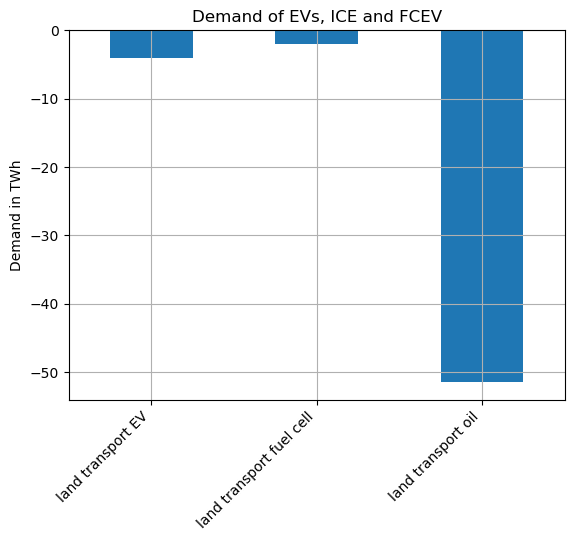

In [91]:
transport_stats_TWh = transport_stats_GWh/1000000

ax = transport_stats_TWh.plot.bar(
    title='Demand of EVs, ICE and FCEV',
    xlabel="",
    ylabel="Demand in TWh"
)

ax.set_xticklabels(transport_stats_GWh.index.get_level_values('carrier'), rotation=45, ha="right")
ax.grid(True) 
plt.show()

### Heating Sector 
The demand of various heating subsectors

In [92]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
heating_stats_GWh = load_stats[load_stats.index.get_level_values('carrier').str.contains('heat', case=False)]
heating_stats_GWh

      carrier                            bus_carrier                     
Load  low-temperature heat for industry  urban central heat                 -2.187786e+06
      residential rural heat             residential rural heat             -1.244755e+04
      residential urban decentral heat   residential urban decentral heat   -8.956664e+04
      services rural heat                services rural heat                -1.189563e+04
      services urban decentral heat      services urban decentral heat      -8.559523e+04
      urban central heat                 urban central heat                 -2.673303e+05
Name: objective, dtype: float64

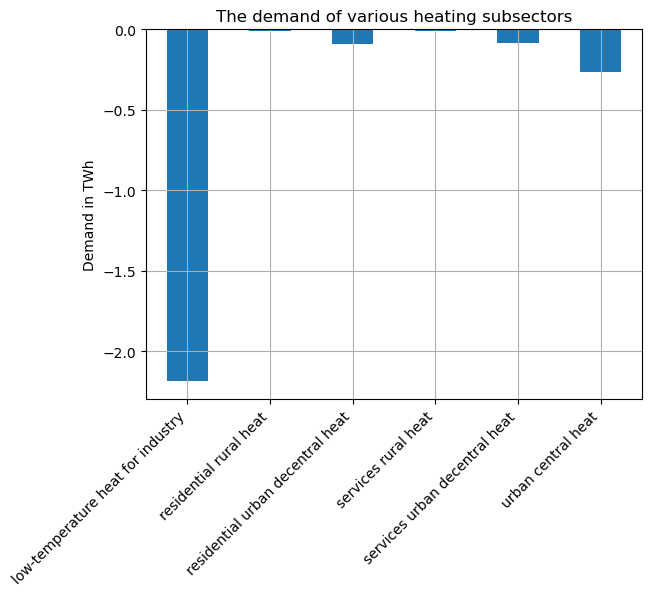

In [93]:
heating_stats_TWh = heating_stats_GWh/1000000

ax = heating_stats_TWh.plot.bar(
    title='The demand of various heating subsectors',
    xlabel="",
    ylabel="Demand in TWh"
)

ax.set_xticklabels(heating_stats_TWh.index.get_level_values('carrier'), rotation=45, ha="right")
ax.grid(True)
plt.show()

How is heating energy supplied (heat pump, district heating, resistive heater, gas boiler)

Gas Boiler: 2408347.6861199117 MWh
Heat Pump: 2542.1674864291435 MWh
Resistive Heater: 244212.44407645066 MWh
CHP: 1171.7998595732581 MWh


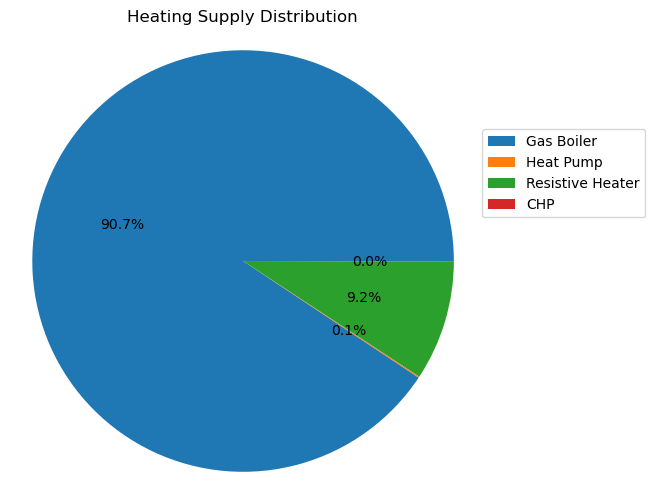

In [94]:
heating_supply_stats = n.statistics.supply(comps=["Link"], aggregate_time="sum").loc[
    lambda x: x.index.get_level_values('carrier').str.contains('heat|boiler|pump|chp', case=False)
]

# Only the Gas boiler, heat pump, CHP, and resistive heater technologies are considered here
heating_types = ['Gas Boiler', 'Heat Pump', 'Resistive Heater', 'CHP']
heating_sums = [heating_supply_stats[heating_supply_stats.index.get_level_values('carrier').str.contains(heatingtype, case=False)].sum() for heatingtype in heating_types]

for ht, sum_value in zip(heating_types, heating_sums):
    print(f"{ht}: {sum_value} MWh")

plt.figure(figsize=(6, 6))
plt.pie(heating_sums, autopct='%1.1f%%')
plt.title('Heating Supply Distribution')
plt.legend(heating_types, loc='upper left', bbox_to_anchor=(1, 0.8))
plt.axis('equal')
plt.show()

### Electricity Sector 
The share of different carriers (capacity and energy)

In [95]:
def color_matching(stats):
    colors = {key.lower(): value.lower() for key, value in config["plotting"]["tech_colors"].items()}
    nice_names = {value.lower(): key for key, value in config["plotting"]["nice_names"].items()}
    color_list = []
    for carrier in stats.index.get_level_values("carrier"):
        original_name = carrier.lower()
        key_name = nice_names.get(original_name, original_name)
        color = colors.get(key_name.lower(), 'gray')
        color_list.append(color)
    return color_list

In [96]:
capacity_stats = n.statistics.installed_capacity(comps=["Generator"])
# Remove carrier with the capacity = 0
capacity_stats_non_zero = capacity_stats[capacity_stats != 0].dropna()
capacity_stats_plus = n.statistics.installed_capacity(comps=["StorageUnit"])
combined_capacity_stats = pd.concat([capacity_stats_non_zero, capacity_stats_plus])
combined_capacity_stats

             carrier           
Generator    Coal                   500.000000
             Combined-Cycle Gas    1838.950905
             Geothermal            1120.000000
             Oil                    150.066350
             Onshore Wind           784.000000
             Open-Cycle Gas         543.978622
             Run of River           398.225382
             Solar                  142.074179
StorageUnit  Reservoir & Dam       4782.961783
Name: p_nom, dtype: float64

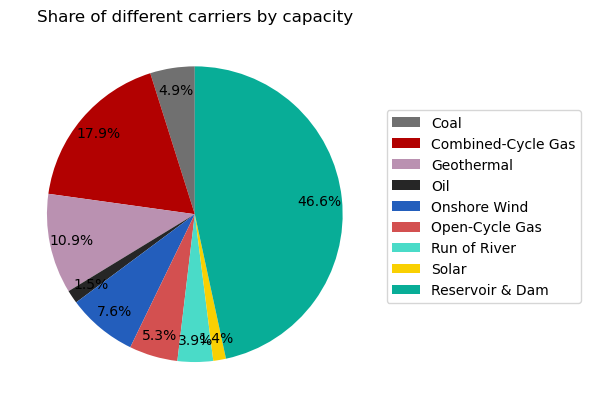

In [97]:
color_list = color_matching(combined_capacity_stats)

combined_capacity_stats.plot.pie(
    title="Share of different carriers by capacity",
    labels=None,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    ylabel="",
    colors=color_list,
)

custom_labels = combined_capacity_stats.index.get_level_values("carrier")
plt.legend(custom_labels, loc='upper left', bbox_to_anchor=(1, 0.8))


In [98]:
energy_stats = n.statistics.energy_balance(comps=["Generator"])
electricity_energy_stats = energy_stats[energy_stats.index.get_level_values('bus_carrier') == 'AC']
electricity_energy_stats_plus = n.statistics.energy_balance(comps=["StorageUnit"])
combined_electricity_energy_stats = pd.concat([electricity_energy_stats, electricity_energy_stats_plus])
combined_electricity_energy_stats

             carrier             bus_carrier
Generator    Coal                AC             3.868327e+06
             Combined-Cycle Gas  AC             2.546595e+06
             Geothermal          AC             9.810376e+06
             Offshore Wind (AC)  AC             3.824497e+00
             Offshore Wind (DC)  AC             4.224329e+00
             Oil                 AC             2.252209e+03
             Onshore Wind        AC             2.748346e+07
             Open-Cycle Gas      AC             8.237255e+04
             Run of River        AC             2.781699e+06
             Solar               AC             2.045476e+07
StorageUnit  Reservoir & Dam     AC             3.252523e+07
dtype: float64

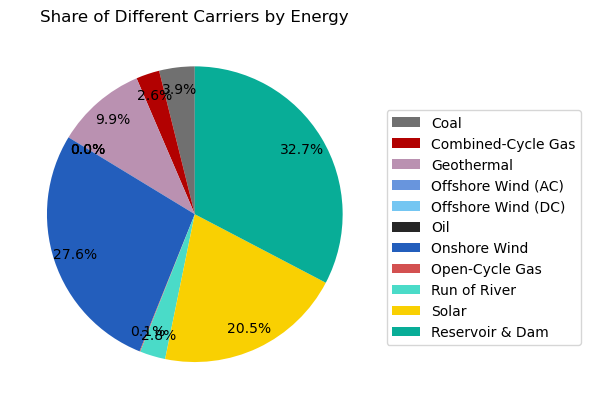

In [99]:
color_list = color_matching(combined_electricity_energy_stats)

combined_electricity_energy_stats.plot.pie(
    title='Share of Different Carriers by Energy',
    labels=None,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    ylabel="",
    colors=color_list,  
)

custom_labels = combined_electricity_energy_stats.index.get_level_values("carrier")
plt.legend(custom_labels, loc='upper left', bbox_to_anchor=(1, 0.8))